In [1]:
import numpy as np
from utils import create_loaders, compute_distance, MAPE
from australian_data_utils import get_australian_data, create_model_loader_train_objects

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import copy

/home/ahmed/.conda/envs/pytorch_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
train_window = 36
horizon = 12

input_dimension = 1
hidden_dimension = 40
batch_size = 256

support_train_loader_dictionary = {}
support_validation_loader_dictionary = {}
support_train_object_dictionary = {}

query_train_loader_dictionary = {}
query_validation_loader_dictionary = {}
query_train_object_dictionary = {}


In [3]:
meta_support_austalian_data = [('NSW', '03'), ('NSW', '18'), ('QLD', '03'), ('QLD', '18'), ('SA', '03')]
meta_query_austalian_data = [('SA', '18'), ('TAS', '07'), ('TAS', '18'), ('VIC', '04'), ('VIC', '18')]


In [4]:
create_model_loader_train_objects(data=meta_support_austalian_data,
                                  train_loader_dictionary=support_train_loader_dictionary, 
                                  validation_loader_dictionary=support_validation_loader_dictionary,
                                  train_object_dictionary=support_train_object_dictionary,
                                  train_window=train_window, hidden_dimension=hidden_dimension, horizon=horizon, batch_size=batch_size,
                                  train_model=True, num_epochs=20)

1- creating objects from NSW on year 03
-----starting training-----
epoch 10 train loss 0.00457 ------ validation loss 0.00441
epoch 20 train loss 0.00421 ------ validation loss 0.00424
epoch 20 train loss 0.00421 ------ validation loss 0.00424
2- creating objects from NSW on year 18
-----starting training-----
epoch 10 train loss 0.00464 ------ validation loss 0.00352
epoch 20 train loss 0.00369 ------ validation loss 0.00319
epoch 20 train loss 0.00369 ------ validation loss 0.00319
3- creating objects from QLD on year 03
-----starting training-----
epoch 10 train loss 0.00470 ------ validation loss 0.00465
epoch 20 train loss 0.00473 ------ validation loss 0.00430
epoch 20 train loss 0.00473 ------ validation loss 0.00430
4- creating objects from QLD on year 18
-----starting training-----
epoch 10 train loss 0.00243 ------ validation loss 0.00258
epoch 20 train loss 0.00271 ------ validation loss 0.00234
epoch 20 train loss 0.00271 ------ validation loss 0.00234
5- creating objects 

In [5]:
create_model_loader_train_objects(data=meta_query_austalian_data,
                                  train_loader_dictionary=query_train_loader_dictionary, 
                                  validation_loader_dictionary=query_validation_loader_dictionary,
                                  train_object_dictionary=query_train_object_dictionary,
                                  train_window=train_window, hidden_dimension=hidden_dimension, horizon=horizon, batch_size=batch_size,
                                  train_model=False)

1- creating objects from SA on year 18
2- creating objects from TAS on year 07
3- creating objects from TAS on year 18
4- creating objects from VIC on year 04
5- creating objects from VIC on year 18


In [6]:
experiment_iteration_result = []
iteration_number = 10
for _ in range(iteration_number):
    distance_list = []
    for key, item in support_train_object_dictionary.items():
        distance_list.append(compute_distance(item.model, item.train_loader, query_train_object_dictionary['train_objectSA18'].train_loader, batch_size, batch_size))
        
    test_object_dictionary = {}
    for i, (k, v) in enumerate(support_train_object_dictionary.items()):
        test_object_dictionary[f'obejct{i+1}'] = copy.deepcopy(query_train_object_dictionary['train_objectSA18'])
        test_object_dictionary[f'obejct{i+1}'].model = v.model
        test_object_dictionary[f'obejct{i+1}'].train(num_epochs=2)
            
    mape_list = []
    mseloss_list = []
    for i, (k, v) in enumerate(support_train_object_dictionary.items()):

        inputs, target = next(enumerate(test_object_dictionary[f'obejct{i+1}'].train_loader, 0))[1]
        inputs = inputs.type(torch.float32).to(test_object_dictionary[f'obejct{i+1}'].learning_parmeters['device'])
        target = target.type(torch.float32).to(test_object_dictionary[f'obejct{i+1}'].learning_parmeters['device'])
        outputs = test_object_dictionary[f'obejct{i+1}'].model(inputs)
        with torch.no_grad():
            mseloss_list.append(nn.MSELoss()(target, outputs).item())
            mape_list.append(MAPE(target, outputs).mean().item())


    experiment_iteration_result.append([distance_list, mape_list, mseloss_list])

-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting traini

In [7]:
average_results = np.mean(experiment_iteration_result, axis=0)

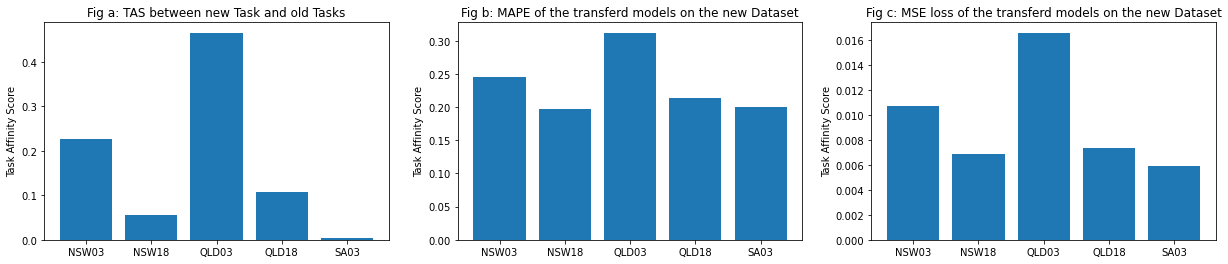

In [8]:
fig, axes = plt.subplots(1, 3,  figsize=(21, 4))
xlabel = [i+j for i, j in meta_support_austalian_data]
axes[0].bar(xlabel, average_results[0])
axes[0].set_ylabel('Task Affinity Score')
axes[0].set_title('Fig a: TAS between new Task and old Tasks')

axes[1].bar(xlabel, average_results[1])
axes[1].set_ylabel('Task Affinity Score')
axes[1].set_title('Fig b: MAPE of the transferd models on the new Dataset')

axes[2].bar(xlabel, average_results[2])
axes[2].set_ylabel('Task Affinity Score')
axes[2].set_title('Fig c: MSE loss of the transferd models on the new Dataset')


plt.show()

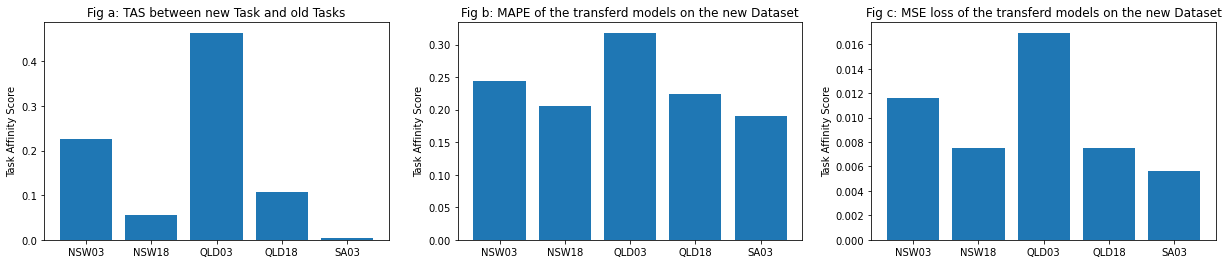

In [9]:
fig, axes = plt.subplots(1, 3,  figsize=(21, 4))
xlabel = [i+j for i, j in meta_support_austalian_data]
axes[0].bar(xlabel, distance_list)
axes[0].set_ylabel('Task Affinity Score')
axes[0].set_title('Fig a: TAS between new Task and old Tasks')

axes[1].bar(xlabel, mape_list)
axes[1].set_ylabel('Task Affinity Score')
axes[1].set_title('Fig b: MAPE of the transferd models on the new Dataset')

axes[2].bar(xlabel, mseloss_list)
axes[2].set_ylabel('Task Affinity Score')
axes[2].set_title('Fig c: MSE loss of the transferd models on the new Dataset')


plt.show()

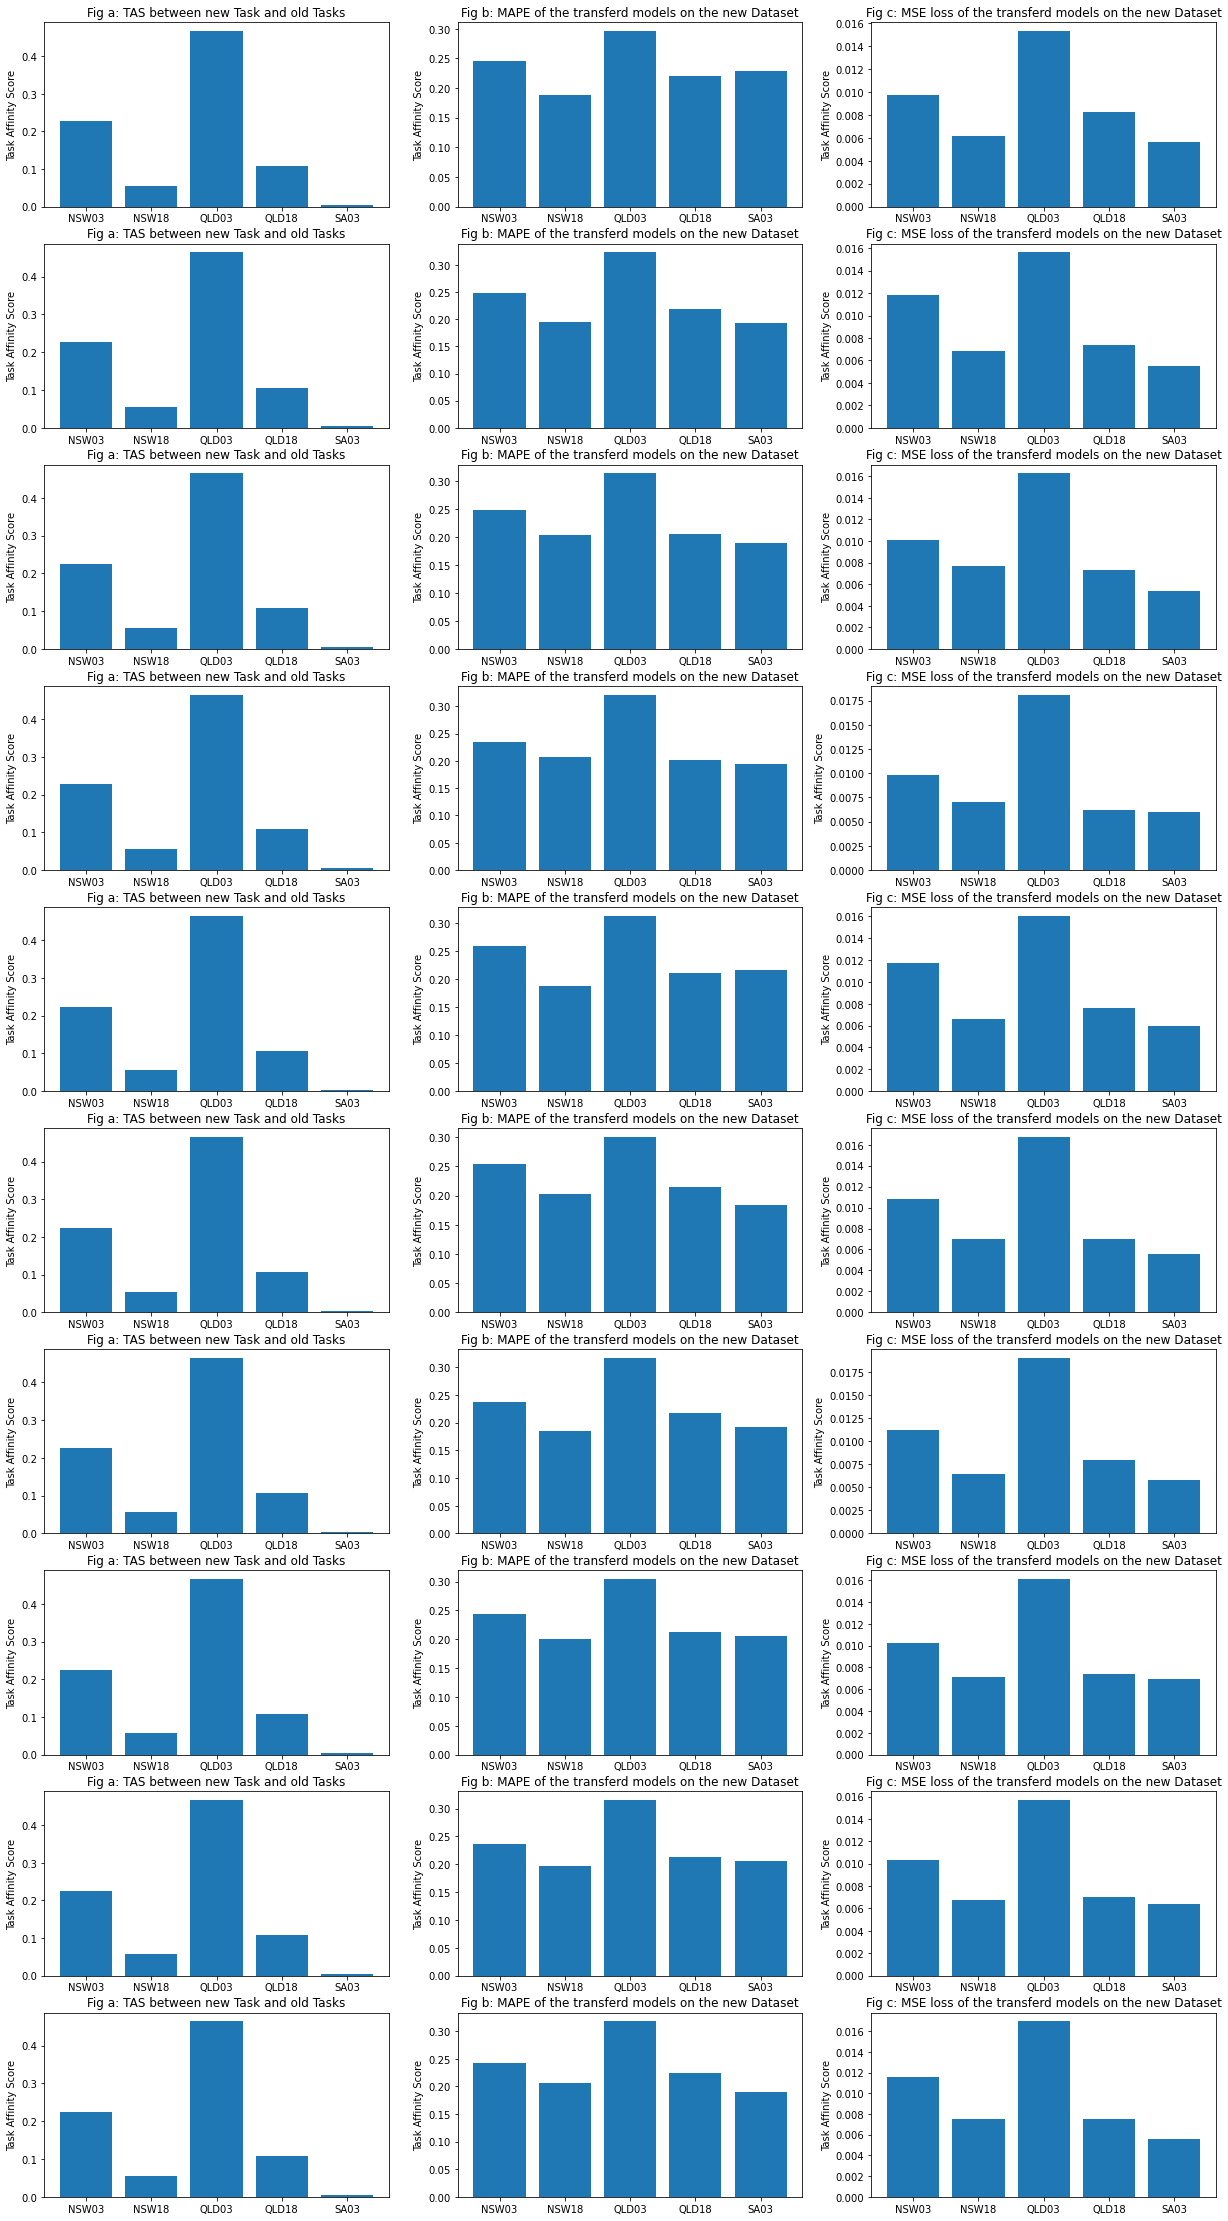

In [10]:

fig, axes = plt.subplots(10, 3,  figsize=(21, 40))
for i in range(10):
    xlabel = [i+j for i, j in meta_support_austalian_data]
    axes[i, 0].bar(xlabel, experiment_iteration_result[i][0])
    axes[i, 0].set_ylabel('Task Affinity Score')
    axes[i, 0].set_title('Fig a: TAS between new Task and old Tasks')

    axes[i, 1].bar(xlabel, experiment_iteration_result[i][1])
    axes[i, 1].set_ylabel('Task Affinity Score')
    axes[i, 1].set_title('Fig b: MAPE of the transferd models on the new Dataset')

    axes[i, 2].bar(xlabel, experiment_iteration_result[i][2])
    axes[i, 2].set_ylabel('Task Affinity Score')
    axes[i, 2].set_title('Fig c: MSE loss of the transferd models on the new Dataset')


plt.show()

In [11]:
from scipy.stats import pearsonr   
for i in range(5):
    print(pearsonr(experiment_iteration_result[i][1], experiment_iteration_result[i][0])[0]*100)


89.4309287435971
99.5119686591985
99.47620713819283
97.60001608455788
94.7220143466885


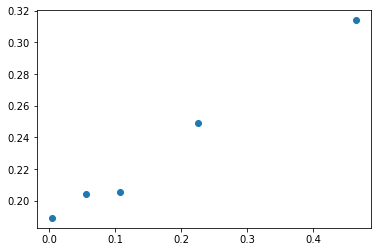

In [12]:
i=2
plt.plot(experiment_iteration_result[i][0], experiment_iteration_result[i][1], 'o')